# Overview

초등학교, 중학교, 고등학교, 대학교와 같은 교육기관에서 우리는 시험을 늘 봐왔습니다. 시험 성적이 높은 과목은 우리가 잘 아는 것을 나타내고 시험 성적이 낮은 과목은 반대로 공부가 더욱 필요함을 나타냅니다. 시험은 우리가 얼마만큼 아는지 평가하는 한 방법입니다.

하지만 시험에는 한계가 있습니다. 우리가 수학 시험에서 점수를 80점 받았다면 우리는 80점을 받은 학생일 뿐입니다. 우리가 돈을 들여 과외를 받지 않는 이상 우리는 우리 개개인에 맞춤화된 피드백을 받기가 어렵고 따라서 무엇을 해야 성적을 올릴 수 있을지 판단하기 어렵습니다. 이럴 때 사용할 수 있는 것이 DKT입니다!

DKT는 Deep Knowledge Tracing의 약자로 우리의 "지식 상태"를 추적하는 딥러닝 방법론입니다.

시험을 보는 것은 동일하지만 단순히 우리가 수학을 80점을 맞았다고 알려주는 것을 넘어서 우리가 수학이라는 과목을 얼마만큼 이해하고 있는지를 측정하여 줍니다. 게다가 이런 이해도를 활용하여 우리가 아직 풀지 않은 미래의 문제에 대해서 우리가 맞을지 틀릴지 예측이 가능합니다!

이런 DKT를 활용하면 우리는 학생 개개인에게 수학의 이해도와 취약한 부분을 극복하기 위해 어떤 문제들을 풀면 좋을지 추천이 가능합니다! 그렇기 때문에 DKT는 교육 AI의 추천이라고도 불립니다. DKT는 맞춤화된 교육을 제공하기 위해 아주 중요한 역할을 맡게 됩니다.

우리는 대회에서 Iscream 데이터셋을 이용하여 DKT모델을 구축할 것입니다. 다만 대회에서는 학생 개개인의 이해도를 가리키는 지식 상태를 예측하는 일보다는, 주어진 문제를 맞출지 틀릴지 예측하는 것에 집중할 것입니다! 우리는 각 학생이 푼 문제 리스트와 정답 여부가 담긴 데이터를 받아 최종 문제를 맞출지 틀릴지 예측할 것입니다!

개인 맞춤화 교육이라는 멋진 미래를 만들기 위한 DKT로 함께 떠나봅시다!

## evaluation metrics

DKT는 주어진 마지막 문제를 맞았는지 틀렸는지로 분류하는 이진 분류 문제입니다! 

그래서 평가를 위해 AUROC(Area Under the ROC curve)와 Accuracy를 사용할 것입니다.

In [1]:
%conda info


     active environment : base
    active env location : /opt/conda
            shell level : 1
       user config file : /opt/ml/.condarc
 populated config files : 
          conda version : 4.10.1
    conda-build version : 3.18.11
         python version : 3.7.7.final.0
       virtual packages : __cuda=10.1=0
                          __linux=4.4.0=0
                          __glibc=2.27=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (writable)
      conda av data dir : /opt/conda/etc/conda
  conda av metadata url : https://repo.anaconda.com/pkgs/main
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /opt/ml/.conda/pkgs


In [2]:
!nvidia-smi

Thu May 27 02:38:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:00:05.0 Off |                  Off |
| N/A   25C    P0    50W / 250W |      0MiB / 24451MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# EDA

In [3]:
import os, sys
from pathlib import Path
from glob import glob

In [4]:
BASE_PATH = Path('.').resolve().parent
BASE_PATH

PosixPath('/opt/ml')

In [5]:
if BASE_PATH.as_posix() not in sys.path:
    sys.path.append(BASE_PATH.as_posix())

In [6]:
sys.path

['/opt/ml/jaepil',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/transformers-4.6.1-py3.8.egg',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/opt/ml/.ipython',
 '/opt/ml']

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import numpy as np
import pandas as pd

In [57]:
import numba
import dask.dataframe as dd

In [9]:
import json
import pickle

In [10]:
from tqdm import tqdm, trange
# from tqdm.notebook import tqdm
from time import time

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.6.0'

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device # Always check cudatoolkit version!

device(type='cuda', index=0)

In [64]:
from collections import defaultdict

## Load data

In [13]:
data_path = BASE_PATH / "input" / "data"
train_path = data_path / "train_dataset"

In [14]:
train_df = pd.read_csv(train_path / "train_data.csv")
test_df = pd.read_csv(train_path / "test_data.csv")
sample_submission_df = pd.read_csv(train_path / "sample_submission.csv")

In [15]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   userID            int64 
 1   assessmentItemID  object
 2   testId            object
 3   answerCode        int64 
 4   Timestamp         object
 5   KnowledgeTag      int64 
dtypes: int64(3), object(3)
memory usage: 103.8+ MB


In [17]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [18]:
len(test_df.userID.unique())

744

In [19]:
sample_submission_df

,id,prediction
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
739,739,0.5
740,740,0.5
741,741,0.5
742,742,0.5


## Preprocess data

이하 EDA는 모두 train dataset만을 대상으로 함. 

### Sorting & Change type

In [20]:
# sort dataset

train_df.sort_values(by=['userID', 'Timestamp'], ignore_index=True, inplace=True)

In [21]:
# change Timestamp format from str to datetime

train_df.Timestamp = pd.to_datetime(train_df.Timestamp)
test_df.Timestamp = pd.to_datetime(test_df.Timestamp)

### Categorical features from existing str features

In [22]:
train_df.loc[:, "test_cat"] = train_df.testId.str[2] # 대분류
train_df.loc[:, "question_num"] = train_df.assessmentItemID.str[7:10]

In [23]:
train_df.test_cat = train_df.test_cat.astype(int) # to save space
train_df.question_num = train_df.question_num.astype(int) # to make it sequential

### timedelta

In [ ]:
# TODO: Fix timedelta

# feat: (EDA) Preprocess initial columns EXCEPT "delta"

# Do not use delta. Current timedelta is inaccurate because:
# - Groupby userID and testId breaks when the user takes the same test more than once. 
# - timedelta should be shifted by one because it is the time answer is submitted. 

In [44]:
%%time

stu_test_groupby = train_df.groupby(['userID', 'testId'])
train_df.loc[:, "delta"] = stu_test_groupby['Timestamp'].diff()

CPU times: user 1min 43s, sys: 664 ms, total: 1min 43s
Wall time: 1min 44s


한`userID`가 같은 `testId`를 여러 번 푸는 경우는 없을까? 

시험을 한 번 보고 3개월 뒤 같은 시험을 또 보고 이러면 Timestamp가 엄청 큰 간격으로 찍혀버린다. 

그러면 당연히 time delta를 구했을 때 매우 긴 시간 (몇 주~ 몇 개월씩) 나올 수 있다. 

아래의 결과를 보면, 실제로 한 사람이 같은 테스트를 6월에 한 번, 8월에 한 번 또 보는 것을 볼 수 있다. 

그 결과 delta로 56days라는 이상한 값이 나와버린다. 

In [50]:
%%time

stu_test_df_l = list(stu_test_groupby)
# stu_test_df_l = [x[1] for x in stu_test_df_l]
more_than_1_test_df_l = [x for x in stu_test_df_l if x[1].Timestamp.max().date() != x[1].Timestamp.min().date()]
len(more_than_1_test_df_l)

CPU times: user 2min 35s, sys: 788 ms, total: 2min 36s
Wall time: 2min 36s


9492

In [54]:
more_than_1_test_df_l[0][1]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_cat,question_num,delta
1166,1,A040155001,A040000155,1,2020-06-21 22:57:14,2111,4,1,NaT
1167,1,A040155002,A040000155,1,2020-06-21 22:57:55,2111,4,2,0 days 00:00:41
1168,1,A040155003,A040000155,0,2020-06-21 22:58:33,2111,4,3,0 days 00:00:38
1169,1,A040155004,A040000155,1,2020-06-21 22:58:49,2111,4,4,0 days 00:00:16
1170,1,A040155005,A040000155,0,2020-06-21 23:00:10,2111,4,5,0 days 00:01:21
1171,1,A040155006,A040000155,0,2020-06-21 23:01:44,2111,4,6,0 days 00:01:34
1397,1,A040155001,A040000155,1,2020-08-17 09:56:27,2111,4,1,56 days 10:54:43
1398,1,A040155002,A040000155,1,2020-08-17 09:57:06,2111,4,2,0 days 00:00:39
1399,1,A040155003,A040000155,1,2020-08-17 09:58:03,2111,4,3,0 days 00:00:57
1400,1,A040155004,A040000155,1,2020-08-17 09:58:29,2111,4,4,0 days 00:00:26


### Quick and dirty solution: Exclude `more_than_1_test_df_l`

이는 이후 correlation clustering을 하기 위함

In [52]:
%%time

no_more_than_1_test_df_l = [x for x in stu_test_df_l if x[1].Timestamp.max().date() == x[1].Timestamp.min().date()]
len(no_more_than_1_test_df_l)

CPU times: user 1min 7s, sys: 36 ms, total: 1min 7s
Wall time: 1min 7s


355672

In [53]:
no_more_than_1_test_df_l[0]

((0, 'A020000172'),
      userID assessmentItemID      testId  answerCode           Timestamp  \
 584       0       A020172001  A020000172           1 2020-10-11 11:06:47   
 585       0       A020172002  A020000172           1 2020-10-11 11:06:56   
 586       0       A020172003  A020000172           1 2020-10-11 11:07:13   
 587       0       A020172004  A020000172           1 2020-10-11 11:07:46   
 588       0       A020172005  A020000172           0 2020-10-11 11:08:20   
 589       0       A020172006  A020000172           0 2020-10-11 11:10:01   
 
      KnowledgeTag  test_cat  question_num           delta  
 584          8132         2             1             NaT  
 585          8132         2             2 0 days 00:00:09  
 586          8132         2             3 0 days 00:00:17  
 587          8132         2             4 0 days 00:00:33  
 588          8132         2             5 0 days 00:00:34  
 589          8132         2             6 0 days 00:01:41  )

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 9 columns):
 #   Column            Dtype          
---  ------            -----          
 0   userID            int64          
 1   assessmentItemID  object         
 2   testId            object         
 3   answerCode        int64          
 4   Timestamp         datetime64[ns] 
 5   KnowledgeTag      int64          
 6   test_cat          int64          
 7   question_num      int64          
 8   delta             timedelta64[ns]
dtypes: datetime64[ns](1), int64(5), object(2), timedelta64[ns](1)
memory usage: 155.6+ MB


## Descriptive statistics

In [27]:
train_df.describe()

,userID,answerCode,KnowledgeTag,test_cat,question_num,delta
count,2.266586e+06,2.266586e+06,2.266586e+06,2.266586e+06,2.266586e+06,1901422
mean,2.087687e+03,6.543784e-01,4.909007e+03,4.704910e+00,3.711972e+00,0 days 04:47:48.008105512
std,1.589365e+03,4.755706e-01,3.302214e+03,2.435221e+00,2.034434e+00,4 days 11:32:51.262545645
min,0.000000e+00,0.000000e+00,2.300000e+01,1.000000e+00,1.000000e+00,0 days 00:00:00
25%,8.000000e+02,0.000000e+00,1.931000e+03,3.000000e+00,2.000000e+00,0 days 00:00:10
50%,1.748000e+03,1.000000e+00,5.258000e+03,5.000000e+00,4.000000e+00,0 days 00:00:27
75%,3.046000e+03,1.000000e+00,7.913000e+03,7.000000e+00,5.000000e+00,0 days 00:01:06
max,7.441000e+03,1.000000e+00,1.127100e+04,9.000000e+00,1.300000e+01,332 days 03:04:38


### 학생별 분석

In [167]:
stu_groupby_agg = train_df.groupby('userID').agg({
    'assessmentItemID': 'count', 
    'answerCode': np.mean,
    'Timestamp': lambda x: (x.max() - x.min()).days, 
    'testId': lambda x: 1 if len(x) != len(set(x)) else 0 # 중복이 있으면 1, 없으면 0
})

In [168]:
(train_df.Timestamp.max() - train_df.Timestamp.min()).days

364

<AxesSubplot:xlabel='assessmentItemID', ylabel='Count'>

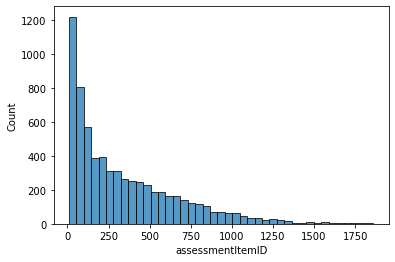

In [169]:
# 학생별 푼 문제 수
sns.histplot(data=stu_groupby_agg.assessmentItemID)

<AxesSubplot:xlabel='answerCode', ylabel='Count'>

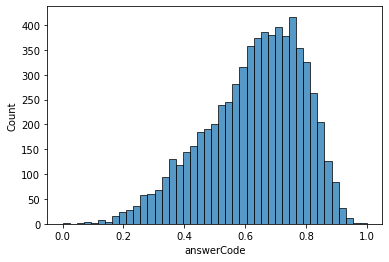

In [170]:
# 학생별 정답률
sns.histplot(data=stu_groupby_agg.answerCode)

<AxesSubplot:xlabel='Timestamp', ylabel='Count'>

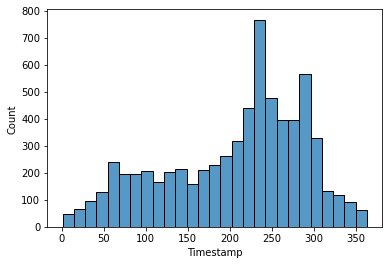

In [171]:
# 학생별 i-Scream 플랫폼에서 문제를 푼 기간 (단위: 일)
sns.histplot(stu_groupby_agg.Timestamp)

<AxesSubplot:ylabel='Count'>

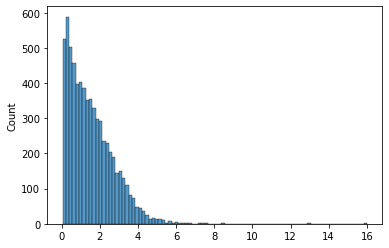

In [172]:
# 학생별 i-Scream 플랫폼 이용기간 중 일평균 푼 문제수
sns.histplot(stu_groupby_agg.assessmentItemID / stu_groupby_agg.Timestamp)

<AxesSubplot:xlabel='testId', ylabel='Count'>

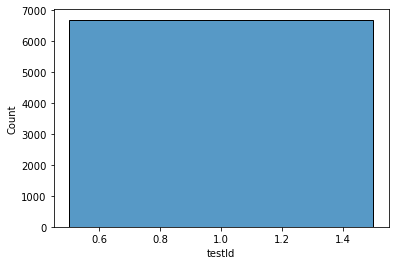

In [173]:
sns.histplot(stu_groupby_agg.testId)

### 문항별 분석

In [179]:
ass_groupby_agg = train_df.groupby('assessmentItemID').agg({
    'userID': 'count', 
    'answerCode': np.mean,
#     'test_cat': 'count' # 무의미. 각 문제는 하나의 테스트 대분류에만 속한다. 
    'delta': lambda x: np.mean(x).seconds
})

<AxesSubplot:xlabel='userID', ylabel='Count'>

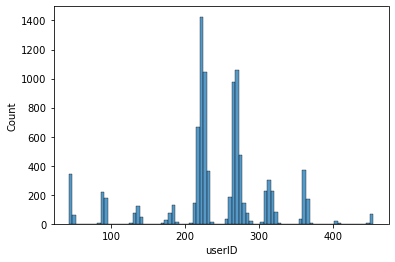

In [81]:
# 문항별로 푼 학생 수 분포 
sns.histplot(ass_groupby_agg.userID)

<AxesSubplot:xlabel='answerCode', ylabel='Count'>

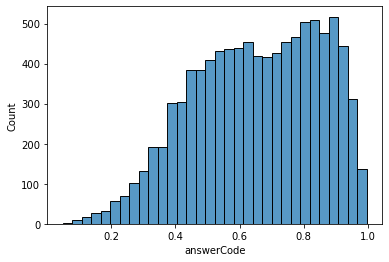

In [82]:
# 문항별 정답률
sns.histplot(ass_groupby_agg.answerCode)

<AxesSubplot:xlabel='delta', ylabel='Count'>

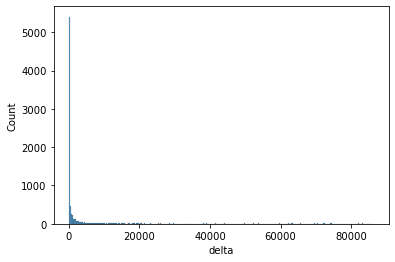

In [180]:
sns.histplot(ass_groupby_agg.delta)

### 시험지별 분석

In [181]:
test_groupby_agg = train_df.groupby('testId').agg({
    'userID': 'count', 
    'answerCode': np.mean,
    'KnowledgeTag': 'count',
    'assessmentItemID': 'count',
    'delta': lambda x: np.mean(x).seconds
})

<AxesSubplot:xlabel='userID', ylabel='Count'>

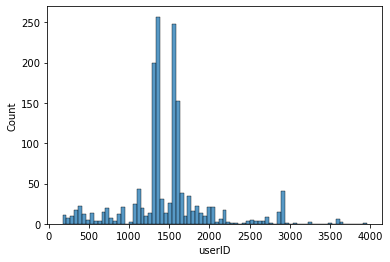

In [84]:
sns.histplot(test_groupby_agg.userID)

<AxesSubplot:xlabel='answerCode', ylabel='Count'>

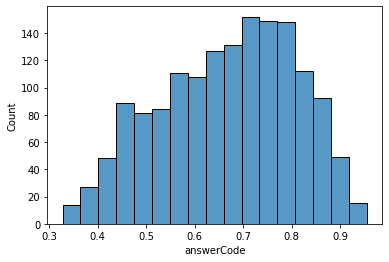

In [85]:
sns.histplot(test_groupby_agg.answerCode)

<AxesSubplot:xlabel='KnowledgeTag', ylabel='Count'>

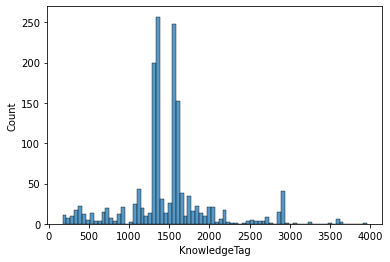

In [86]:
sns.histplot(test_groupby_agg.KnowledgeTag)

<AxesSubplot:xlabel='assessmentItemID', ylabel='Count'>

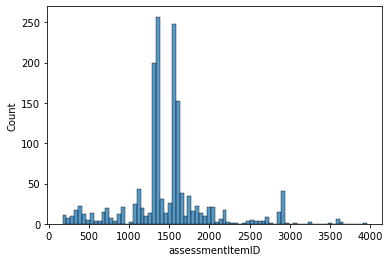

In [112]:
sns.histplot(test_groupby_agg.assessmentItemID)

<AxesSubplot:xlabel='delta', ylabel='Count'>

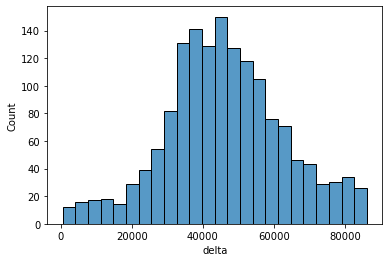

In [182]:
sns.histplot(test_groupby_agg.delta)

### knowledge tag 별 분석

In [183]:
kt_groupby_agg = train_df.groupby('KnowledgeTag').agg({
    'userID': 'count', 
    'answerCode': np.mean,
    'assessmentItemID': 'count',
#     'test_cat': 'count' # 무의미. 각 문제는 하나의 테스트 대분류에만 속한다. 
    'delta': lambda x: np.mean(x).seconds
})

<AxesSubplot:xlabel='userID', ylabel='Count'>

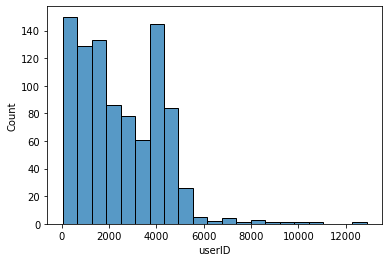

In [88]:
sns.histplot(kt_groupby_agg.userID)

<AxesSubplot:xlabel='answerCode', ylabel='Count'>

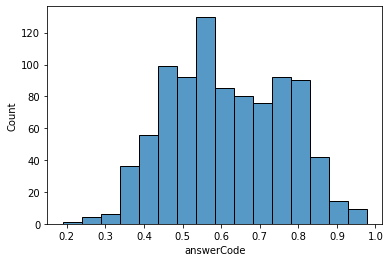

In [89]:
sns.histplot(kt_groupby_agg.answerCode)

<AxesSubplot:xlabel='assessmentItemID', ylabel='Count'>

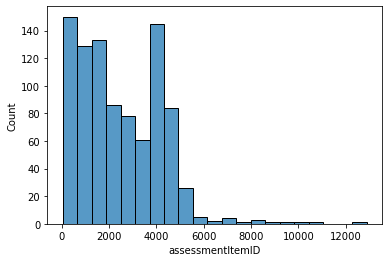

In [90]:
sns.histplot(kt_groupby_agg.assessmentItemID)

<AxesSubplot:xlabel='delta', ylabel='Count'>

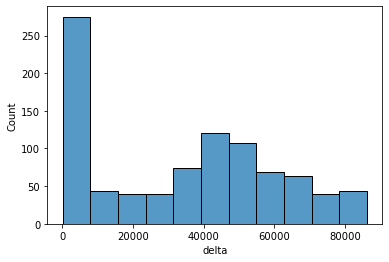

In [184]:
sns.histplot(kt_groupby_agg.delta)